In [49]:
# exec(open('/home/DIDE/sjbhatt/BH_notebooks/new paper/final/SARS COV1 experiment.py').read())
import numpyro
from tqdm import tqdm
from jax import random
from numpyro.infer import MCMC, NUTS
import numpyro.distributions as dist
from numba import jit, njit,prange
import numba as nb
from numba.numpy_support import from_dtype
from numba import njit, objmode
from jax.lib import xla_bridge
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
import jax as jax
import arviz as az
import os
import matplotlib.style
import matplotlib as mpl
import matplotlib.pylab as pylab
from scipy.linalg import toeplitz
import scipy as scipy
from jax.config import config
config.update("jax_enable_x64", True)
#numpyro.enable_x64()
#numpyro.set_platform("cpu")
#numpyro.set_host_device_count(20)
#%matplotlib inline
print(xla_bridge.get_backend().platform)
print(jax.local_device_count())

gpu
2


In [50]:

@njit(parallel=True)
def quick_mean(R):
    N = np.shape(R)[0]
    F = np.zeros((N, N))
    F[:, 0] = 1
    for c in prange(0, N):
        for t in range(1, c+1):
            convolution = 0
            for u in range(1, t+1):
                convolution += R[c-t+u]*GG[u,c-t]*v[u]*F[c, t-u]
            F[c, t] = 1 + convolution
    return np.diag(F)
@njit(parallel=False)
def pgf(s,R,phi,T):
        p = phi/(phi+1)
        N = np.shape(R)[0]
        Fg = np.zeros((N,N))+0j
        Fg[:, 0] = s*GG[0,0]
        for c in range(0, N):
            for t in range(1, c+1):               
                outside_integral = 0+0j
                initial_condition = 0+0j
                initial_condition_integral = 0+0j
                index = t+1
                if t+1>T:
                    index=T
                for u in range(0, index):
                    inside_integral = 0+0j
                    for k in range(0, u):
                        inside_integral +=(np.log(1-(1-p)*Fg[c, t-k]) - np.log(p)) * R[c-t+k]* v[k]
                    outside_integral += np.exp(-phi*(inside_integral)) * gg[u,c-t]
                for u in range(1, index):
                    initial_condition_integral += (np.log(1-(1-p)*Fg[c, t-u]) - np.log(p)) * R[c-t+u]* v[u]
                initial_condition =  GG[t,c-t] * s * np.exp(-phi*(initial_condition_integral))
                Fg[c, t] = initial_condition + s*outside_integral
        return np.diag(Fg)
@njit(parallel=False)
def pgf_approx(s,R,phi,T):
    p = phi/(phi+1)
    N = np.shape(R)[0]
    Fg = np.zeros((N,N))+0j
    Fg[:, 0] = s
    for c in range(0, N):
        for t in range(1, c+1):               
            initial_condition = 0+0j
            initial_condition_integral = 0+0j
            index = t+1
            if t+1>T:
                index=T
            for u in range(1, index):
                initial_condition_integral += (np.log(1-(1-p)*Fg[c, t-u]) - np.log(p)) * R[c-t+u]* v[u]
            initial_condition =  s * np.exp(-phi*(initial_condition_integral))
            Fg[c, t] = initial_condition 
    return np.diag(Fg)
@njit(parallel=True)
def compute_pmf(M,R,phi,T):
    N = np.shape(R)[0]
    num = np.zeros((M, N))+0j
    for m in prange(0, M):
        num[m, :] = np.transpose(pgf_approx(np.exp(2.0*np.pi*1j*m/M),R,phi,T))
    pmf = np.zeros((M, N), dtype=np.float64)
    for i in prange(N):
        with objmode(out='float64[:]'):
            out = np.real(np.fft.fft(num[:, i]))
        normalise = out*(out >= 0)
        pmf[:, i] = normalise
        pmf[:, i] = pmf[:, i]/np.sum(pmf[:, i])
    return pmf
def mean(pmf):
    N=pmf.shape[1]
    M = np.shape(pmf)[0]
    mn = np.zeros(N)
    loc = np.linspace(0, M-1, M)
    for i in range(N):
        mn[i] = np.sum(pmf[:, i]*loc)
    return mn
def CI(pmf):
    N=pmf.shape[1]
    quant = np.zeros((N,2))
    for i in range(N):
        cdf = np.cumsum(pmf[:, i])
        quant[i,0] = np.argmax(cdf>=0.025)
        quant[i,1] = np.argmax(cdf>=0.975)
    return quant
@njit(parallel=False)
def decompose_variance(R,phi,prevalence):
    N = np.shape(R)[0]
    V = np.zeros((N, N))
    V_it = np.zeros((N, N))
    V_ni = np.zeros((N, N))

    F = np.zeros((N, N))
    store1 = np.zeros((N, N))
    store2 = np.zeros((N, N))
    store3 = np.zeros((N, N))
    F[:, 0] = GG[0,0]
    V[:, 0] = 0
    V_it[:, 0] = 0
    V_ni[:, 0] = 0
    EYsq = 1+(1/phi)
    for c in range(0, N):
        for t in range(1, c+1):
            convolution = 0
            term1=0 # G
            term2=0 # 2GM
            term3=0 # G M^2 
            term4=0 # Int Sg
            term5=0 # V
            term6=0 # MY
            term7=0 # -M^2
            term2_integral=0
            term3_integral=0
            convolutionS = 0
            term5_it=0 # V
            term5_ni=0 # V            
            for u in range(0, t+1):
                convolution +=  R[c-t+u] * GG[u,c-t] * v[u] * F[c, t-u]
            if prevalence:
                F[c, t] = GG[t,c-t] + convolution
            else:
                F[c, t] = 1 + convolution            
            for u in range(0,t+1):
                term4_integral = 0
                if prevalence:
                    term2_integral += R[c-t+u] * v[u] * F[c, t-u] 
                else:
                    term2_integral += R[c-t+u] * v[u] * F[c, t-u] * GG[u,c-t]              
                term3_integral += R[c-t+u] * v[u] * F[c, t-u] 
                term5 += R[c-t+u] * GG[u,c-t] * v[u] * V[c, t-u]
                term5_it += R[c-t+u] * GG[u,c-t] * v[u] * V_it[c, t-u]
                term5_ni += R[c-t+u] * GG[u,c-t] * v[u] * V_ni[c, t-u]
                term6 += R[c-t+u] * GG[u,c-t] * v[u] * np.square(F[c, t-u]) * EYsq
                for q in range(0,u):
                    term4_integral += R[c-t+q] * v[q] * F[c, t-q]
                term4 += np.square(term4_integral)*gg[u,c-t]
            if prevalence:
                term1 = GG[t,c-t]
                term2 = 2 * GG[t,c-t] * term2_integral
                term3 = np.square(term3_integral)*GG[t,c-t]
            else:
                term1 = 1
                term2 = 2 * term2_integral
                term3 = np.square(term3_integral)*GG[t,c-t]                
            term7 = np.square(F[c, t])
            V[c,t] = term1 + term2 + term3 + term4 + term5 + term6 - term7
            V_it[c,t] = term1 + term2 + term3 + term4 + term5_it - term7
            V_ni[c,t] = term5_ni + term6
            V[c,t] = term1 + term2 + term3 + term4 + term5 + term6 - term7
            store1[c,t] = term1 + term4 + term2 + term3  - term7
            store2[c,t] = term5
            store3[c,t] = term6 

    output = np.zeros((N,7))
    output[:,0]= np.diag(F)     
    output[:,1]= np.diag(V) 
    output[:,2]= np.diag(store1) 
    output[:,3]= np.diag(store2) 
    output[:,4]= np.diag(store3) 
    output[:,5]= np.diag(V_it)
    output[:,6]= np.diag(V_ni)
    return output    
def prop_decomp(decomp):
    it = decomp[:,2]
    v = decomp[:,3]
    ni = decomp[:,4]
    tot = it+v+ni
    v_it = decomp[:,5]
    v_ni = decomp[:,6]
    output = np.zeros((it.shape[0],5)) 
    output[:,0]=it/tot
    output[:,1]=v/tot
    output[:,2]=ni/tot
    output[:,3]=(v/tot)*(v_it/tot)
    output[:,4]=(v/tot)*(v_ni/tot)
    return output

def process_proportions(fitted_R,phi,prevalence):
    N =  fitted_R.shape[1]
    it = np.zeros((num_samples,N))
    ni = np.zeros((num_samples,N))
    v = np.zeros((num_samples,N))
    v_it = np.zeros((num_samples,N))
    v_ni = np.zeros((num_samples,N))    
    for i in tqdm(range(num_samples)):
        R = fitted_R[i,:]
        decomp=prop_decomp(decompose_variance(R,phi,prevalence))
        it[i,:]=decomp[:,0]
        v[i,:]=decomp[:,1]
        ni[i,:]=decomp[:,2]
        v_it[i,:]=decomp[:,3]
        v_ni[i,:]=decomp[:,4]

    output = np.zeros((N,3*5))
    output[:,0] = np.quantile(it,axis=0,q=0.025)
    output[:,1] = np.mean(it,0)
    output[:,2] = np.quantile(it,axis=0,q=0.975)
    output[:,3] = np.quantile(v,axis=0,q=0.025)
    output[:,4] = np.mean(v,0)
    output[:,5] = np.quantile(v,axis=0,q=0.975)
    output[:,6] = np.quantile(ni,axis=0,q=0.025)
    output[:,7] = np.mean(ni,0)
    output[:,8] = np.quantile(ni,axis=0,q=0.975)
    output[:,9] = np.quantile(v_it,axis=0,q=0.025)
    output[:,10] = np.mean(v_it,0)
    output[:,11] = np.quantile(v_it,axis=0,q=0.975)
    output[:,12] = np.quantile(v_ni,axis=0,q=0.025)
    output[:,13] = np.mean(v_ni,0)
    output[:,14] = np.quantile(v_ni,axis=0,q=0.975)
    return output


In [51]:
addition = 0 # how long to seed for
def load_data(PLOT):
#    original data
#    data=np.array([1,0,0,1,0,0,2,0,2,2,1,1,1,0,0,0,4,1,2,4,13,23,35,26,12,17,19,17,28,23,27,27,11,21,21,25,31,103,96,69,58,48,33,25,43,37,30,29,28,34,34,32,24,17,16,23,18,15,11,19,16,9,17,14,6,4,8,9,11,11,11,6,13,3,8,2,4,4,6,4,5,4,8,2,3,2,5,3,3,4,3,1,2,0,1,3,3,1,1,1,1,1,1,1,0,2,0])
#   zeros for end of epidemic appended
    data=np.array([1,0,0,1,0,0,2,0,2,2,1,1,1,0,0,0,4,1,2,4,13,23,35,26,12,17,19,17,28,23,27,27,11,21,21,25,31,103,96,69,58,48,33,25,43,37,30,29,28,34,34,32,24,17,16,23,18,15,11,19,16,9,17,14,6,4,8,9,11,11,11,6,13,3,8,2,4,4,6,4,5,4,8,2,3,2,5,3,3,4,3,1,2,0,1,3,3,1,1,1,1,1,1,1,0,2,0,0,0,0,0,0,0,0])
    g=np.array([0.000,0.001,0.012,0.043,0.078,0.104,0.117,0.116,0.108,0.094,0.078,0.063,0.049,0.038,0.028,0.021,0.015,0.011,0.008,0.005,0.004,0.003,0.002,0.001,0.001])    
    
    T=g.shape[0]
    data = np.append(np.repeat(0,addition),data)
    # generate time points
    x=np.linspace(0,data.size-1,data.size)
    # serial interval and padding
    g_raw=g
    g=np.append(g,np.zeros(data.size-g.size))
    g=g/np.sum(g)
    # survival function 
    G=np.abs(1-np.cumsum(g))
    # data size
    n=data.size
    v = g
    # put on jax
    y = np.array(data)

   
    g=np.zeros(n)
    g1 = np.squeeze(g)
    G1 = 1-np.cumsum(g1)

    g2=g1
    G2=G1
    gg=np.zeros((n,n))
    GG=np.zeros((n,n))
    HH=np.zeros((n,n))

    # i = life length
    # j = born at this time
    isolation_time = np.argmax(y)+1 # day after amoy gardens outbreak max isolation started

    for j in range(n):
        for i in range(n):
            if j<=isolation_time:
                gg[i,j] = g1[i] # g switch
                GG[i,j] = G1[i] # G switch
                HH[i,j] = 0 # for cumulative incidence (no death)
            else:
                gg[i,j] = g2[i]
                GG[i,j] = G2[i]
                HH[i,j] = 0
    if PLOT:
        plt.plot(g1[:T])
        plt.plot(g2[:T])
        plt.plot(v[:T])

    M=n-1
    A_H = np.transpose(np.tile(np.arange(0, M + 1), (M + 1, 1)))
    B_H = toeplitz(np.arange(0, M + 1))

    A_L = A_H[0 : M, 0 : M]
    B_L = np.tile(np.flip(np.arange(1, M + 1)), (M, 1))
    
    return y,n,G1,G2,x,data,T,g_raw,g1,g2,v,gg,GG,HH, A_H,B_H,A_L,B_L,isolation_time

In [52]:
def Fit_new(y,v,M,A_L,B_L,HH):    
    def lam(u, tau,R):
        return R[u + tau]  * v[u]
    def vectorized(L):
        m=n-1
        F = jnp.zeros(shape = (m + 1, m + 1))
        F=F.at[:, 0].set(1)
        for i in range(m):
            B = F[(i + 1) : (m + 1), 0 : (i + 1)] * L[0 : (m - i), (m - i - 1) : (m + 1)]
            F=F.at[(i + 1) : (m + 1), i + 1].set(jnp.sum(B, axis = -1))
        return(jnp.diag(F))
    y,v,M,A_L,B_L,HH  = map(jnp.asarray, (y,v,M,A_L,B_L,HH))
#    phi = numpyro.sample("phi", dist.TruncatedNormal(loc=0.16,scale=0.05,low=0))
    phi = numpyro.sample("phi", dist.HalfNormal(1))

    n = y.size

    sigma = numpyro.sample("sigma", dist.Exponential(100))
    rho_star = numpyro.sample("R_d", dist.GaussianRandomWalk(scale=sigma, num_steps=n)) 
    R = numpyro.deterministic('R',jnp.exp(rho_star))

    L = lam(B_L, A_L,R)  
    inc = numpyro.deterministic("incidence",vectorized(L))
    prod = jnp.sum(M*y,axis=1)[1:]
    mean = R[1:]*prod+1e-18
    p = 1 - phi/(1+phi)
    r = phi*mean
    mn = numpyro.deterministic("mn",r*(p/(1-p)))
    numpyro.sample('obs', dist.NegativeBinomialProbs(r,p), obs=y[1:])      
  
warmup=1000
num_samples=6000
target_accept_prob=0.99
max_tree_depth=15
kernel_new = NUTS(Fit_new,target_accept_prob=target_accept_prob,max_tree_depth=max_tree_depth)
kernel_new_forecast = NUTS(Fit_new,target_accept_prob=target_accept_prob,max_tree_depth=max_tree_depth)

y,n,G1,G2,x,data,T,g_raw,g1,g2,v,gg,GG,HH,A_H,B_H,A_L,B_L,isolation_time = load_data(False)

M = np.zeros((n,n))
for i in range(n):
    for j in range(0,i):
        M[i,j] = v[i-j]   
y=np.float64(y)
R=jnp.ones(n)
v=jnp.array(v)


In [53]:
pathnew='/home/DIDE/sjbhatt/fitnew.nc'
RUN=True
if RUN:
    if os.path.exists(pathnew):
        os.remove(pathnew) 
    mcmc = MCMC(kernel_new, num_warmup=warmup, num_samples=num_samples,progress_bar=True,num_chains=2,jit_model_args=True)
    rng_key = random.PRNGKey(1234)
    mcmc.run(rng_key, y,v,M,A_L,B_L,HH)
    post = mcmc.get_samples()
    numpyro_data2 = az.from_numpyro(mcmc)
    numpyro_data2.to_netcdf(pathnew)
mnew = az.from_netcdf(pathnew)


/home/DIDE/sjbhatt/anaconda3/lib/python3.7/site-packages/numpyro/util.py:313: UserWarning: We will disable progress bar because it does not work yet on multi-GPUs platforms.
  "We will disable progress bar because it does not work yet on multi-GPUs platforms."


In [54]:
icn = np.vstack(np.array(mnew.posterior['incidence']))
mn = np.vstack(np.array(mnew.posterior['mn']))
rn = np.vstack(np.array(mnew.posterior['R']))
phin = np.hstack(np.array(mnew.posterior['phi']))

dates_plot=np.linspace(0,n-1,n)
yplot = y


In [55]:
store=np.zeros((rn.shape[0],rn.shape[1]-1))

def Fit_forecast(R,M,phi,mean_in):    
    R,M,phi,mean_in  = map(jnp.asarray, (R,M,phi,mean_in))
    Bins = numpyro.sample("bins", dist.HalfNormal(jnp.ones(n-mean_in.shape[0])*1e7))
    y = numpyro.deterministic('incidence',jnp.append(mean_in,Bins))
    prod = jnp.sum(M*y,axis=1)[1:]
    R = R.at[mean_in.shape[0]:].set(R[mean_in.shape[0]])
    mean = R[1:]*prod+1e-18
    p = 1 - phi/(1+phi)
    r = phi*mean
    mn = numpyro.deterministic("mean",r*(p/(1-p)))
    log_density =  dist.NegativeBinomialProbs(r,p).log_prob(y[1:])
    numpyro.factor("density", log_density)

def run(R,phi,y,start):
    warmup=500
    num_samples=2000
    kernel = NUTS(Fit_forecast)
    mcmc = MCMC(kernel, num_warmup=warmup, num_samples=num_samples,progress_bar=True,num_chains=1,jit_model_args=True)
    rng_key = random.PRNGKey(125)
    mcmc.run(rng_key, R,M,phi,y[:start])
    post = mcmc.get_samples()
    inc = post['incidence']
    mn = post['mean']
    return mn,inc


In [56]:
start=60
indhigh = np.argmax(rn[:,start],0)
indlow = np.argmin(rn[:,start],0)
indlow = np.argsort(rn[:,start])[int(0.025*mn.shape[0])]
indhigh = np.argsort(rn[:,start])[int(0.975*mn.shape[0])]
print(print(rn[indlow,start],rn[indhigh,start]))
store1l,store2l = run(rn[indlow,:],phin[indlow],y,start)
store1h,store2h = run(rn[indhigh,:],phin[indhigh],y,start)


  0%|          | 0/2500 [00:00<?, ?it/s]

0.3831419608717395 0.8323942092505706
None


sample: 100%|██████████| 2500/2500 [00:22<00:00, 118.12it/s, 15 steps of size 2.51e-01. acc. prob=0.90]


In [57]:
mcn = np.cumsum(np.vstack(np.array(mnew.posterior['incidence'])),1)
rcn = np.vstack(np.array(mnew.posterior['R']))
ind = np.arange(0,mcn.shape[0]-1,mcn.shape[0])
ind_low = np.argsort(mcn[:,-1])[int(0.025*mcn.shape[0])]
ind_high = np.argsort(mcn[:,-1])[int(0.975*mcn.shape[0])]
Rl = rcn[ind_low,:]
Rh = rcn[ind_high,:]
phi = np.mean(phin)

Rl, Rh, v, phi = map(np.float32,(Rl, Rh, v, phi))
num=30000
dispersionl=phin[ind_low]
dispersionh=phin[ind_high]

pmf1 = compute_pmf(num,Rh,dispersionh,T)
pmf2 = compute_pmf(num,Rl,dispersionl,T)

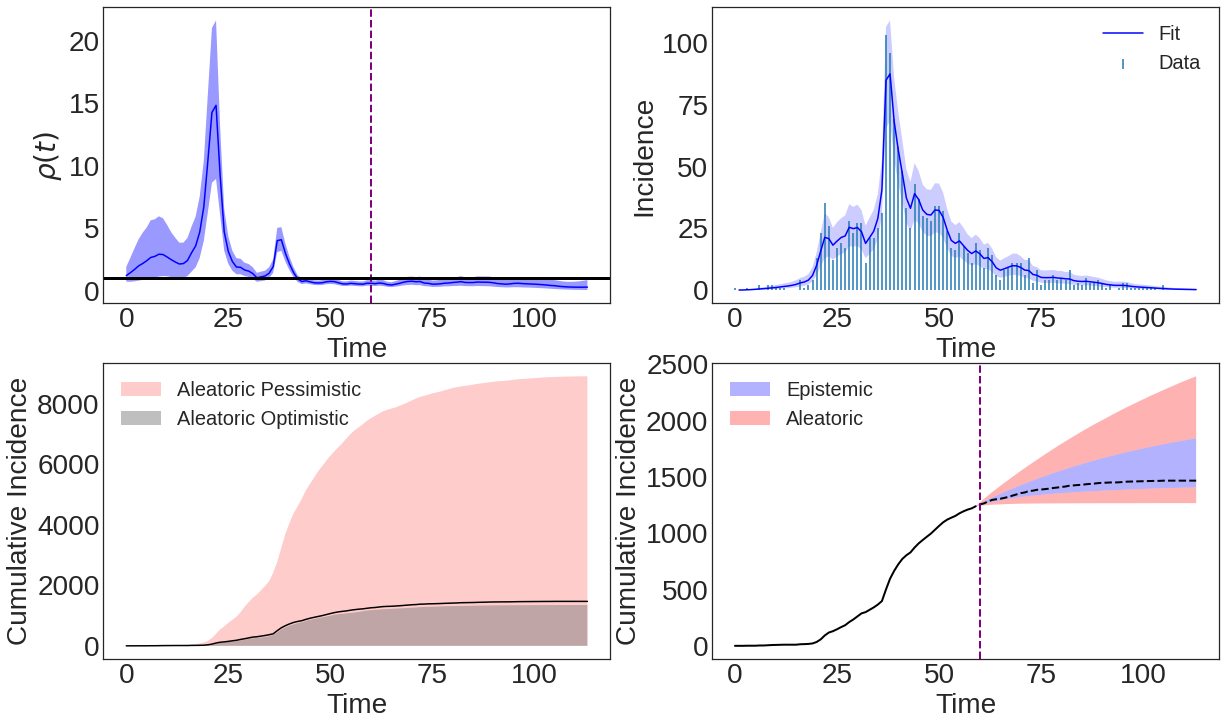

In [68]:
import matplotlib.style
import matplotlib as mpl
import matplotlib.pylab as pylab

# use latex for font rendering
#mpl.rcParams['text.usetex'] = True
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
mpl.style.use('seaborn-white')
env = 'firebrick'
plt.rcParams['text.usetex'] = False


SMALL_SIZE = 12
MEDIUM_SIZE = 20
BIGGER_SIZE = 28

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE) 

fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(20,12))

ax1.plot(dates_plot,np.mean(rn,0),color='blue')
ax1.axvline(x=start,color='purple',linestyle='dashed',linewidth=2)
ax1.fill_between(dates_plot, np.quantile(rn,axis=0,q=0.025),np.quantile(rn,axis=0,q=0.975), facecolor='blue', alpha=0.4)
ax1.axhline(y=1,color='black',linewidth=3)
ax1.set_xlabel("Time")
ax1.set_ylabel("$\\rho(t)$")

dates_plot1 = dates_plot[1:]
ax2.stem(dates_plot,yplot,markerfmt=' ',basefmt=' ',label='Data')
ax2.plot(dates_plot1,np.mean(mn,0),color='blue',label='Fit')
ax2.fill_between(dates_plot1, np.quantile(mn,axis=0,q=0.025),np.quantile(mn,axis=0,q=0.975), facecolor='blue', alpha=0.2)
ax2.set_xlabel("Time")
ax2.set_ylabel("Incidence")
ax2.legend(loc='upper right',fancybox=True,ncol=1)


#ax3.fill_between(x,mean(pmf2),mean(pmf1),facecolor='gray',alpha=0.4,label='Aleatoric Mean')
ax3.fill_between(x,CI(pmf1)[:,0],CI(pmf1)[:,1],facecolor='red',alpha=0.2,label='Aleatoric Pessimistic')
ax3.fill_between(x,CI(pmf2)[:,0],CI(pmf2)[:,1],facecolor='gray',alpha=0.5,label='Aleatoric Optimistic')
ax3.plot(x,np.cumsum(y),color='black')
ax3.set_yticks([0,2000,4000,6000,8000])
ax3.set_xlabel("Time")
ax3.set_ylabel("Cumulative Incidence")
ax3.legend(loc='upper left',fancybox=True,ncol=1)



ax4.fill_between(x,np.cumsum(np.mean(store2h,0)),np.cumsum(np.mean(store2l,0)),alpha=0.3,facecolor='blue',label="Epistemic")
ax4.fill_between(x,np.cumsum(np.quantile(store2h,axis=0,q=0.975)),np.cumsum(np.mean(store2h,0)),alpha=0.3,facecolor='red',label="Aleatoric")
ax4.fill_between(x,np.cumsum(np.mean(store2l,0)),np.cumsum(np.quantile(store2l,axis=0,q=0.025)),alpha=0.3,facecolor='red')
ax4.plot(x[:start],np.cumsum(y)[:start],color='black',linewidth=2)
ax4.plot(x[start:],np.cumsum(y)[start:],color='black',linestyle='dashed',linewidth=2)
ax4.axvline(x=start,color='purple',linestyle='dashed',linewidth=2)
ax4.set_yticks([0,500,1000,1500,2000,2500])
ax4.set_xlabel("Time")
ax4.set_ylabel("Cumulative Incidence")
ax4.legend(loc='upper left',fancybox=True,ncol=1)

savefigurepath = '/home/DIDE/sjbhatt/BH_notebooks/new paper/Fit_SARSCOV1.pdf'
plt.savefig(savefigurepath,bbox_inches='tight')

In [61]:
CI(pmf1)[-1,1]/np.cumsum(y)[-1]

6.062031356509884

In [66]:
CI(pmf2)[-1,1]/np.cumsum(y)[-1]

0.9188820722563054

In [67]:
np.cumsum(np.quantile(store2h,axis=0,q=0.975))[-1]/np.cumsum(np.mean(store2h,0))[-1]

DeviceArray(1.29923461, dtype=float64)